## Summary

To have the flow differing from poiseuille flow within $1e-10$, we need to be $7R$ away from the obstruction in the tube. 

In [1]:
import numpy as np
import sys
sys.path.append('../src/')
import geometry
from matplotlib import pyplot as plt
from scipy.special import p_roots
from scipy.sparse.linalg import gmres

In [2]:
tube = geometry.obstructed_tube(N=4096)
a, da, t, dt_da, k = tube.get_data()

x = t.real
y = t.imag
u = 1 - y**2
v = np.zeros(len(a))
u[np.abs(t.real) <= 1] = 0

h2 = u
h1 = -v

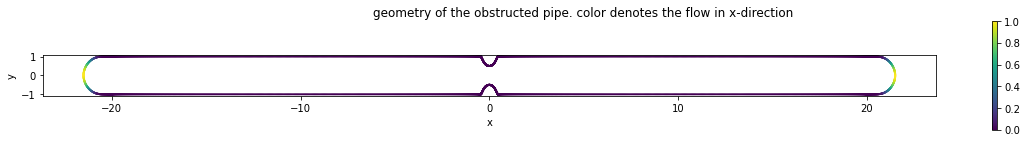

In [4]:
fig, ax = plt.subplots(figsize=(20,2))
ax.scatter(t.real, t.imag, c=u,s=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
im = ax.set_aspect(1)
fig.suptitle('geometry of the obstructed pipe. color denotes the flow in x-direction')
fig.colorbar(im)

## solving the flow

In [5]:
def kernels(t,dt_da,h,curvature):
    dt = t[:,np.newaxis] - t[np.newaxis,:]
    d = dt_da[np.newaxis,:]
    hh = h[np.newaxis,:]
    
    # this ignore the error for computing the diagonal elements with 0/0 error
    with np.errstate(divide='ignore',invalid='ignore'):
        K1 = -hh * np.imag(d/dt) / np.pi
        K2 = -hh * (-d/np.conjugate(dt) + np.conjugate(d)*dt/(np.conjugate(dt**2))) / (2j*np.pi)
    # now we need to fill the diagonal elements
    d = dt_da
    K1_diagonal = curvature*np.abs(d)*h/(2*np.pi)
    K2_diagonal = -h*curvature*(d**2)/(np.abs(d)*2*np.pi)
    np.fill_diagonal(K1,K1_diagonal)
    np.fill_diagonal(K2,K2_diagonal)
    
    return K1,K2

In [6]:
K1, K2 = kernels(t, dt_da, da, k)

In [7]:
n = len(t)

In [8]:
A = np.zeros((2*n,2*n))
A[:n,:n] = np.identity(n) + (K1+K2).real
A[:n,n:] = (-K1+K2).imag
A[n:,:n] = (K1+K2).imag
A[n:,n:] = np.identity(n) + (K1-K2).real
rhs = np.concatenate((h1,h2))

In [9]:
omega, _ = gmres(A, rhs, tol=1e-12)
if _ == 0:
    print('gmres converged')
else:
    print('gmres did not converge')

omega = omega[:n] + 1j*omega[n:]

gmres converged


In [10]:
def evaluation(z,omega,t,da,dt_da):
    
    d_t = dt_da*da
    t_minus_z = t-z
    t_minus_z_square = t_minus_z**2
    
    phi = np.sum(omega*d_t/t_minus_z)/(2j*np.pi)
    d_phi = np.sum(omega*d_t/(t_minus_z**2))/(2j*np.pi)
    
    psi = (1/(2j*np.pi))*(
        2*np.sum(np.real(np.conjugate(omega)*d_t)/t_minus_z)
        - np.sum(np.conjugate(t)*omega*d_t/t_minus_z_square))
    
    dW = phi + z*np.conjugate(d_phi) + np.conjugate(psi)
    
    return dW


In [19]:
grid = np.array([(x[i], yy) for i in range(np.argmax(t.real)+1,np.argmin(t.real)-2) 
                 for yy in np.linspace(y[i], -y[i], 70)][1:-1])
grid_x, grid_y = grid.T
grid_z = grid_x + 1j*grid_y
with np.errstate(divide='ignore',invalid='ignore'):
    grid_val = np.array([evaluation(z,omega,t,da,dt_da) for z in grid_z])

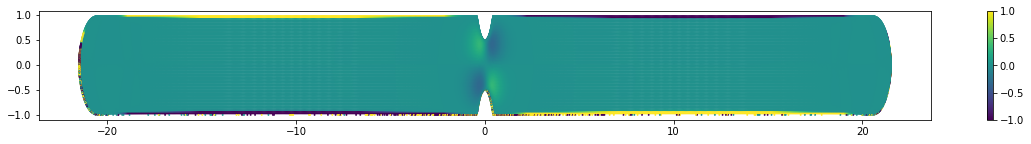

In [20]:
plt.figure(figsize=(20,2))
plt.scatter(grid_x, grid_y, c=grid_val.real, s=.8, vmin=-1, vmax=1)
plt.colorbar()

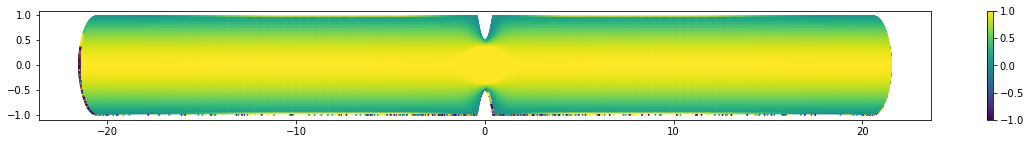

In [21]:
plt.figure(figsize=(20,2))
plt.scatter(grid_x, grid_y, c=grid_val.imag, s=.8, vmin=-1, vmax=1)
plt.colorbar()

Text(0.5, 0.98, 'the values of poiseuille flow and the solved flow. color denotes the value. ')

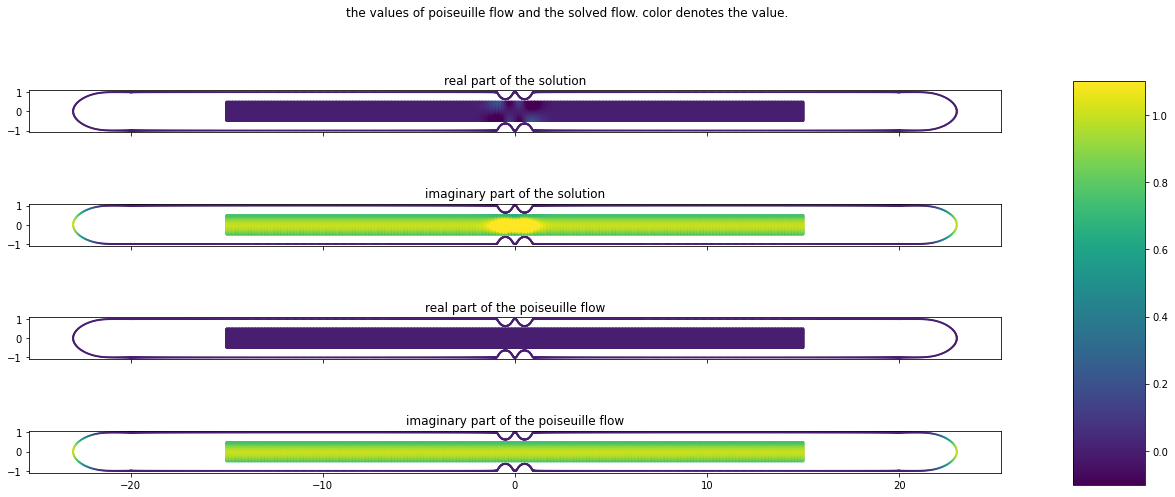

In [191]:

fig, axes = plt.subplots(4,1,figsize=(20,8),sharex=True)

vmin = -0.1
vmax = 1.1

axes[0].set_title('real part of the solution')
axes[0].scatter(t.real,t.imag,c=h1 ,s=1,vmin=vmin,vmax=vmax)
axes[0].scatter(grid_x,grid_y,c=grid_val.real,s=1,vmin=vmin,vmax=vmax)
axes[0].set_aspect('equal')

axes[1].set_title('imaginary part of the solution')
axes[1].scatter(t.real,t.imag, c=h2,s=1,vmin=vmin,vmax=vmax)
axes[1].scatter(grid_x,grid_y,c=grid_val.imag,s=1,vmin=vmin,vmax=vmax)
axes[1].set_aspect('equal')

axes[2].set_title('real part of the poiseuille flow')
axes[2].scatter(t.real,t.imag, c=h1,s=1,vmin=vmin,vmax=vmax)
axes[2].scatter(grid_x,grid_y,c=poiseuille_val.real,s=1,vmin=vmin,vmax=vmax)
axes[2].set_aspect('equal')

axes[3].set_title('imaginary part of the poiseuille flow')
im = axes[3].scatter(t.real,t.imag, c=h2,s=1,vmin=vmin,vmax=vmax)
axes[3].scatter(grid_x,grid_y,c=poiseuille_val.imag,s=1,vmin=vmin,vmax=vmax)
axes[3].set_aspect('equal')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('the values of poiseuille flow and the solved flow. color denotes the value. ')

## regions where the solved flow differed from the poiseuille flow within $1e-10$

Text(0.5, 0.98, 'difference for the poiseuille flow and the solved flow. color denotes the value. ')

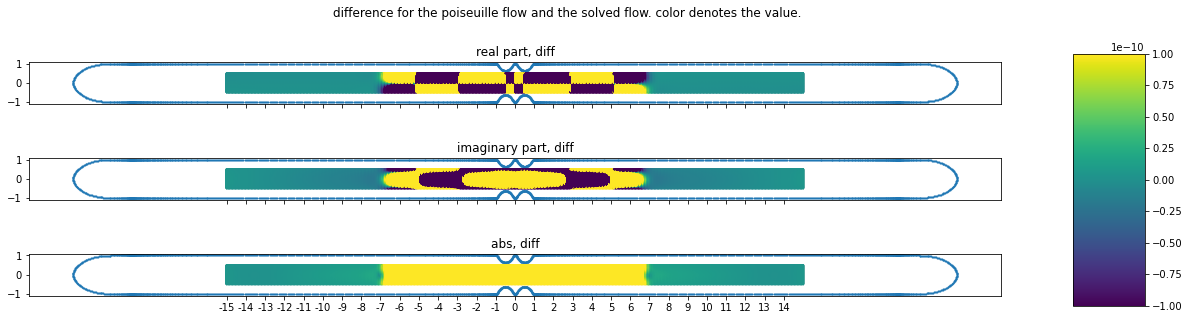

In [192]:
fig, axes = plt.subplots(3,1,figsize=(20,5),sharex=True)

diff = grid_val - poiseuille_val
vmin = -1e-10
vmax = 1e-10

axes[0].set_title('real part, diff')
axes[0].scatter(t.real,t.imag,s=1)
axes[0].scatter(grid_x,grid_y,c=diff.real,s=1,vmin=vmin,vmax=vmax)
axes[0].set_aspect('equal')

axes[1].set_title('imaginary part, diff')
axes[1].scatter(t.real,t.imag,s=1)
axes[1].scatter(grid_x,grid_y,c=diff.imag,s=1,vmin=vmin,vmax=vmax)
axes[1].set_aspect('equal')

axes[2].set_title('abs, diff')
axes[2].scatter(t.real,t.imag,s=1)
im = axes[2].scatter(grid_x,grid_y,c=np.abs(diff),s=1,vmin=vmin,vmax=vmax)
axes[2].set_aspect('equal')
axes[2].set_xticks(np.arange(-15,15,1))
axes[2].set_xticklabels(np.arange(-15,15,1))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('difference for the poiseuille flow and the solved flow. color denotes the value. ')

according to the colorbar, bule regions are the region that difference from the poiseuille flow and solved flow has a small difference within $1e-10$. This requires that 
$$
|x| \ge 7 R
$$

## regions where the solved flow differed from the poiseuille flow within $1e-11$

Text(0.5, 0.98, 'difference for the poiseuille flow and the solved flow. color denotes the value. ')

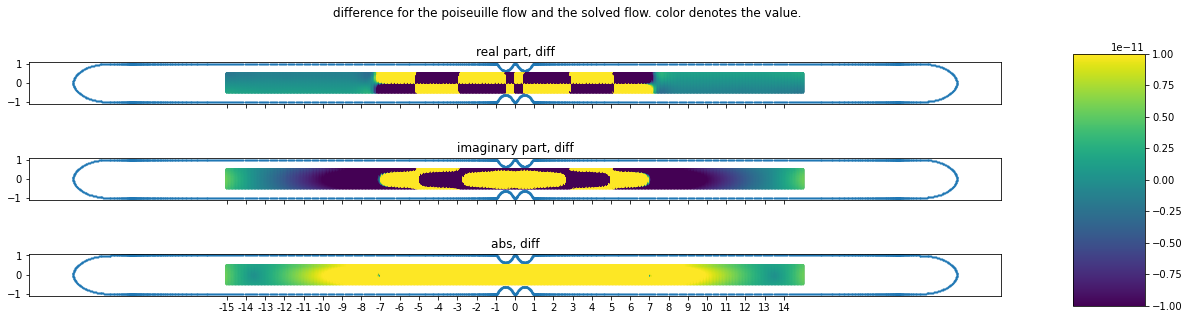

In [194]:
fig, axes = plt.subplots(3,1,figsize=(20,5),sharex=True)

diff = grid_val - poiseuille_val
vmin = -1e-11
vmax = 1e-11

axes[0].set_title('real part, diff')
axes[0].scatter(t.real,t.imag,s=1)
axes[0].scatter(grid_x,grid_y,c=diff.real,s=1,vmin=vmin,vmax=vmax)
axes[0].set_aspect('equal')

axes[1].set_title('imaginary part, diff')
axes[1].scatter(t.real,t.imag,s=1)
axes[1].scatter(grid_x,grid_y,c=diff.imag,s=1,vmin=vmin,vmax=vmax)
axes[1].set_aspect('equal')

axes[2].set_title('abs, diff')
axes[2].scatter(t.real,t.imag,s=1)
im = axes[2].scatter(grid_x,grid_y,c=np.abs(diff),s=1,vmin=vmin,vmax=vmax)
axes[2].set_aspect('equal')
axes[2].set_xticks(np.arange(-15,15,1))
axes[2].set_xticklabels(np.arange(-15,15,1))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle('difference for the poiseuille flow and the solved flow. color denotes the value. ')

you can see that in this case, there is really no obvious region with differences bounded by $1e-11$. As $|x|$ grows larger after $14R$, the difference starts to grow again. I suspect that to get a better convergences, we need to put the caps more far away. 